In [1]:
using Pkg
# Pkg.activate(".")
# Pkg.instantiate()
using Revise
using EasyHybrid
using Lux
using Optimisers
using WGLMakie
using Random
using LuxCore
using CSV, DataFrames
using EasyHybrid.MLUtils
using Statistics
using Plots
using JLD2


In [2]:
# 03 - flexiable BD, both oBD and mBD will be learnt by NN
testid = "mend_hybridNN";
version = "v20251209"
results_dir = joinpath(@__DIR__, "eval");
target_names = [:BD, :SOCconc, :CF, :SOCdensity];

# input
df = CSV.read(joinpath(@__DIR__, "data/lucas_preprocessed_v20251125.csv"), DataFrame; normalizenames=true)
println(size(df))

# scales
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);

# mechanistic model
function SOCD_model(; SOCconc, CF, oBD, mBD)
    ϵ = 1e-7

    # invert transforms
    soct = (exp.(SOCconc ./ scalers[:SOCconc]) .- 1) ./ 1000
    soct = clamp.(soct, ϵ, Inf)
    
    cft = (exp.(CF ./ scalers[:CF]) .- 1) ./ 100
    cft = clamp.(cft, 0, 0.99)

    # compute BD safely
    som = 1.724f0 .* soct
    som = clamp.(som, 0, 1) # test!!!!!!!!
    
    denom = som .* mBD .+ (1f0 .- som) .* oBD
    # denom = clamp.(denom, ϵ, Inf)

    BD = (oBD .* mBD) ./ denom
    BD = clamp.(BD, ϵ, Inf)

    # SOCdensity
    SOCdensity = soct .* 1000 .* BD .* (1 .- cft)
    SOCdensity = clamp.(SOCdensity, 1, Inf)

    # scale
    SOCdensity = log.(SOCdensity) .* scalers[:SOCdensity]
    BD = BD .* scalers[:BD]

    return (; BD, SOCconc, CF, SOCdensity, oBD, mBD)
end


# param bounds
parameters = (
    SOCconc = (0.01f0, 0.0f0, 1.0f0),   # fraction
    CF      = (0.15f0, 0.0f0, 1.0f0),   # fraction,
    oBD     = (0.20f0, 0.05f0, 0.40f0),  # also NN learnt, g/cm3
    mBD     = (1.20f0, 0.75f0, 2.0f0),  # NN leanrt
)

# define param for hybrid model
neural_param_names = [:SOCconc, :CF, :mBD, :oBD]
# global_param_names = [:oBD]
forcing = Symbol[]
targets = [:BD, :SOCconc, :SOCdensity, :CF]       # SOCconc is both a param and a target

# predictor
predictors = Symbol.(names(df))[18:end-6]; # CHECK EVERY TIME 
nf = length(predictors)


(56117, 385)


362

In [3]:
# hyperparameters
# search space
hidden_configs = [ 
    (512, 256, 128, 64, 32, 16),
    (512, 256, 128, 64, 32), 
    (256, 128, 64, 32, 16),
    (256, 128, 64, 32),
    (256, 128, 64),
    (128, 64, 32, 16),
    (128, 64, 32),
    (64, 32, 16)
];
batch_sizes = [128, 256, 512];
lrs = [1e-3, 5e-4, 1e-4];
activations = [relu, swish, gelu];

configs = [(h=h, bs=bs, lr=lr, act=act)
           for h in hidden_configs
           for bs in batch_sizes
           for lr in lrs
           for act in activations]

println(length(configs))


216


In [4]:
# cross-validation
Random.seed!(42);
k = 5;
folds = make_folds(df, k = k, shuffle = true);
rlt_list_param = Vector{DataFrame}(undef, k)
rlt_list_pred = Vector{DataFrame}(undef, k)  

@info "Threads available: $(Threads.nthreads())"

[ Info: Threads available: 96


In [5]:

@time for test_fold in 1:k
    @info "Training outer fold $test_fold of $k"

    train_folds = setdiff(1:k, test_fold)
    train_idx = findall(in(train_folds), folds)
    train_df = df[train_idx, :]
    test_idx  = findall(==(test_fold), folds)
    test_df = df[test_idx, :]

    # track best config for this outer fold
    lk = ReentrantLock()
    best_val_loss = Inf
    best_config = nothing
    best_result = nothing
    best_model_path = nothing
    best_model = nothing

    Threads.@threads for i in 1:length(configs)
        try
            cfg = configs[i]
        
            h  = cfg.h
            bs = cfg.bs
            lr = cfg.lr
            act = cfg.act
            println("Testing h=$h, bs=$bs, lr=$lr, activation=$act")
    
            hm_local = constructHybridModel(
                predictors,
                forcing,
                targets,
                SOCD_model,
                parameters,
                neural_param_names,
                [];
                hidden_layers = collect(h),
                activation = act,
                scale_nn_outputs = true,
                input_batchnorm = false,
                start_from_default = true
            )
    
            rlt = train(
                hm_local, train_df, ();
                nepochs = 200,
                batchsize = bs,
                opt = AdamW(lr),
                training_loss = :mse,
                loss_types = [:mse, :r2],
                shuffleobs = true,
                file_name = "$(testid)_config$(i)_fold$(test_fold).jld2",
                random_seed = 42,
                patience = 15,
                yscale = identity,
                monitor_names = [:oBD, :mBD],
                agg = mean,
                return_model = :best,
                show_progress = false,
                plotting = false,
                hybrid_name = "$(testid)_config$(i)_fold$(test_fold)" 
            )
    
            lock(lk)
            if rlt.best_loss < best_val_loss
                best_val_loss = rlt.best_loss
                best_config = cfg
                best_result = rlt
                best_model_path = "best_model_$(testid)_config$(i)_fold$(test_fold).jld2"
                best_model = deepcopy(hm_local)
            end
            unlock(lk)
        catch err
            @error "Thread $i crashed" exception = err
            @error sprint(showerror, err)
        end

    end

    # register best hyper paramets
    agg_name = Symbol("mean")
    r2s  = map(vh -> getproperty(vh, agg_name), best_result.val_history.r2)
    mses = map(vh -> getproperty(vh, agg_name), best_result.val_history.mse)
    best_epoch = max(best_result.best_epoch, 1)

    local_results_param = DataFrame(
        h = string(best_config.h),
        bs = best_config.bs,
        lr = best_config.lr,
        act = string(best_config.act),
        r2 = r2s[best_epoch],
        mse = mses[best_epoch],
        best_epoch = best_epoch,
        test_fold = test_fold,
        path = best_model_path,
    )
    rlt_list_param[test_fold] = local_results_param

    # move best models and then remove tmp files
    cp(joinpath("output_tmp", best_model_path), joinpath("model", best_model_path * ".jld2"); force=true) 
    for f in readdir("output_tmp"; join=true)
        rm(f; force=true, recursive=true)
    end

    ps, st = best_result.ps, best_result.st
    (x_test,  y_test)  = prepare_data(best_model, test_df)
    ŷ_test, st_test = best_model(x_test, ps, LuxCore.testmode(st))
    # println(propertynames(ŷ_test))
    # println(propertynames(ŷ_test.parameters))

    for var in [:BD, :SOCconc, :CF, :SOCdensity, :oBD, :mBD]
        if hasproperty(ŷ_test, var)
            val = getproperty(ŷ_test, var)

            if val isa AbstractVector && length(val) == nrow(test_df)
                test_df[!, Symbol("pred_", var)] = val # per row

            elseif (val isa Number) || (val isa AbstractVector && length(val) == 1)
                test_df[!, Symbol("pred_", var)] = fill(Float32(val isa AbstractVector ? first(val) : val), nrow(test_df))
            end


        end
    end
    
    rlt_list_pred[test_fold] = test_df

end

rlt_param = vcat(rlt_list_param...)
rlt_pred = vcat(rlt_list_pred...)

CSV.write(joinpath(results_dir, "$(testid)_cv.pred_$version.csv"), rlt_pred)
CSV.write(joinpath(results_dir, "$(testid)_hyperparams_$version.csv"), rlt_param)

[ Info: Training outer fold 1 of 5


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014474941764612483
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014474941764612483
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014968548994431792
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014968548994431792
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014805656034305354
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.

Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=5

[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.0185154803575299
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.0185154803575299


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.01442275623483301
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.01442275623483301
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.018230670416491908
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.018230670416491908


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014543309344977207
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014543309344977207
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015002580020963583
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015002580020963583


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014878715374046687
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014878715374046687
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.014608353054796953
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.014608353054796953
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014720447279763502
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014720447279763502
┌ Warning: Early stopping a

Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014773082041621192
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014773082041621192


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.018132683507621136
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.018132683507621136


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014661526669652952
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014661526669652952
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.02062854980227826
└ @ E

Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.017744810184828406
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.017744810184828406


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014431457980173607
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014431457980173607


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.017710721705776356
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.017710721705776356


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.018808212535495236
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.018808212535495236


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.014936171334017328
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.014936171334017328


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014961508086638193
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.014961508086638193


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.02168213066453982
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.02168213066453982
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 63 with best validation loss wrt mse: 0.014663525911477512
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 48 of 200 epochs with best validation loss wrt mse: 0.014663525911477512


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.014541629833401428
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.014541629833401428


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014546702916204118
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014546702916204118
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014979338904033062
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01470301475321853
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01470301475321853


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.019861298358556705
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.019861298358556705


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014536839652891315
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014536839652891315
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01451311939430307
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01451311939430307
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.016498057830998197
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014570177904494056
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014570177904494056
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.017447802014232718
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.017447802014232718


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01454405383422833
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01454405383422833
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014160051373864961
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014160051373864961
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014539246538370956
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014539246538370956
┌ Warning: Early stopping at e

Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.0170008157885553
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.0170008157885553
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.0147083570054823
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.0147083570054823


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.01500281173632427
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.01500281173632427
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01472715007733986
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01472715007733986


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.018061226740411187
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.018061226740411187
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.02143135129037485
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.02143135129037485
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014501887305951696
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015008110826058747
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015008110826058747


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014890618324080982
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014890618324080982


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.019831335506599136
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.019831335506599136
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.014666625004969253
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.014666625004969253


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01723290908931248
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01723290908931248


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014500431951007007
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014500431951007007
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014804438323209181
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014804438323209181
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.016949627072452404
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014575103537571753
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014575103537571753
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01668638327926133
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01668638327926133


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014772038836160586
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.014772038836160586


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014680118343772508
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014680118343772508
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.017762189298761416
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.017762189298761416
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014849798664548284
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.018251934648006347
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.018251934648006347


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01476765315552649
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01476765315552649
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014404506111139175
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014404506111139175


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014377600431186334
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014377600431186334
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014575384088576039
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014575384088576039
┌ Warning: Early stopping at epoch 89 with best validation loss wrt mse: 0.019015584339504017
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 74 of 200 epochs with best validation loss wrt mse: 0.019015584339504017
[ Info: Check the saved out

Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014537238653625025
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014537238653625025


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014648209020664524
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014648209020664524
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.019033250842049862
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.019033250842049862
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation los

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01437339131909501
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01437339131909501


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014749920445418646
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014749920445418646
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.020258571081724158
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.020258571081724158
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014859705733064619
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014859705733064619
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved out

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 79 with best validation loss wrt mse: 0.017973163051528726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 64 of 200 epochs with best validation loss wrt mse: 0.017973163051528726
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014629066783219314
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014629066783219314


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.021290837003439658
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.021290837003439658


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.0148589928738661
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.0148589928738661
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.021155837398997887
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.021155837398997887
[ Info: Check the saved output (.png, .mp4, .jld2) from training a

Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.019607990288749898
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.019607990288749898
┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.024189238293698956
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 68 of 200 epochs with best validation loss wrt mse: 0.024189238293698956


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.015020246668400287
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.015020246668400287
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014179001154271351
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014179001154271351


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.018843716714038276
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.018843716714038276


Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.017838574109226533
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.017838574109226533
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 117 with best validation loss wrt mse: 0.01826512887862864
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 102 of 200 epochs with best validation loss wrt mse: 0.01826512887862864
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.014670306815232657
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning b

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015001383267811913
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015001383267811913
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014165702804466728
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014165702804466728


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.017782470739940666
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.017782470739940666
┌ Warning: Early stopping at epoch 61 with best validation loss wrt mse: 0.0216162246883575
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 46 of 200 epochs with best validation loss wrt mse: 0.0216162246883575


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014271647087975913
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014271647087975913


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014424750573346742
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014424750573346742


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014543132257644894
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014543132257644894
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.017616716036009426
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.017616716036009426


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014519481145442801
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014519481145442801
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014801013369246942
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014801013369246942


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014430287489294381
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014430287489294381
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.018889656012028685
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.018889656012028685
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01754562601746605
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01754562601746605
[ Info: Check the saved outp

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.01675400772653344
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.01675400772653344
┌ Warning: Early stopping at epoch 87 with best validation loss wrt mse: 0.02245503177323735
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 72 of 200 epochs with best validation loss wrt mse: 0.02245503177323735
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.02016971040926408
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.02016971040926408


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014446228309287447
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014446228309287447
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014799407101129263
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014799407101129263
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.014987239334035965
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.014987239334035965
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping a

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.0147893760259671
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.0147893760259671
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014500639110739951
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014500639110739951
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01423634088169048
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01423634088169048
┌ Warning: Early stopping at epoch

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.01504321819919564
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.01504321819919564
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014782422436584829
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014782422436584829
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.0178150960503225
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.0178150960503225
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epo

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014569464914275666
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014569464914275666
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014322175238353569
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014322175238353569
┌ Warning: Early stopping at epoch 109 with best validation loss wrt mse: 0.023328364010740486
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 94 of 200 epochs with best validation loss wrt mse: 0.023328364010740486


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014559123096437478
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014559123096437478
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.016370276103284315
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.016370276103284315


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.022226954974598666
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 42 of 200 epochs with best validation loss wrt mse: 0.022226954974598666


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015019535076844764
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015019535076844764
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014312522878359414
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.014312522878359414


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014856997724847214
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014856997724847214
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.019897816680292932
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.019897816680292932
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014440576422236945
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014440576422236945
┌ Warning: Early stopping a

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.01653951431367573
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 34 of 200 epochs with best validation loss wrt mse: 0.01653951431367573
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014353263154119836
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014353263154119836


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.02113592931543849
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.02113592931543849
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015076425092748242
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015076425092748242
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014634108431241508
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014634108431241508
┌ Warning: Early stopping at

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.014356591816548471
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.014356591816548471


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 80 with best validation loss wrt mse: 0.01710062534188648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 65 of 200 epochs with best validation loss wrt mse: 0.01710062534188648


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014445351245407752
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014445351245407752
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014244497750711339
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014244497750711339


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014653483860847723
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014653483860847723


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01431371017686974
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01431371017686974


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014531305566640092
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014531305566640092
┌ Warning: Early stopping at epoch 117 with best validation loss wrt mse: 0.021450921384094934
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 102 of 200 epochs with best validation loss wrt mse: 0.021450921384094934


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014772983782017603
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014772983782017603
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014474254431781668
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014474254431781668
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014679640550077134
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014321171643739604
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014321171643739604
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014568621225734598
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014568621225734598
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014734155151008182
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014734155151008182
┌ Warning: Early stopping at

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014578895054760474
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014578895054760474
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014211430946359918
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014211430946359918


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 115 with best validation loss wrt mse: 0.018854509916945254
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 100 of 200 epochs with best validation loss wrt mse: 0.018854509916945254


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.014470587339432768
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.014470587339432768
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014431037719031108
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014431037719031108
┌ Warning: Early stopping at epoch 141 with best validation loss wrt mse: 0.018982868341213162
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 126 of 200 epochs with best validation loss wrt mse: 0.018982868341213162


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014243586874464812
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014243586874464812
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014270858582319874
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014270858582319874


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014326493230911992
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014326493230911992
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014559017650157545
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014559017650157545
[ Info: Training outer fold 2 of 5


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish
Testing h=(25

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[

Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013806948560437043
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013806948560437043
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.01700539800191641
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.01700539800191641
[ Info: Plotting disabled.
┌ Warning:

Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=256, l

[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.0188138516958396
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.0188138516958396
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017267926149822165
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.017267926149822165


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.017297264495392727
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.017297264495392727


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013665465059022091
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013665465059022091


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.016627036295221463
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.016627036295221463


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013627066627698761
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013627066627698761
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.016366103616122764
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.016366103616122764


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.014080774385825001
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.014080774385825001


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013940306279540453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013940306279540453


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.013804355246750258
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.013804355246750258
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.014088086297048795
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.014088086297048795


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013849249774997324
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013849249774997324
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.013725156651835883
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.016150061105882876
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.016150061105882876


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.013914937456603613
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.013914937456603613
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.01699311851405797
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.01699311851405797


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.0139603470569182
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.0139603470569182


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01390337410544754
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01390337410544754


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.017697617112809788
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.017697617112809788
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014154807833334865
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014154807833334865


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013893527112168437
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013893527112168437
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.013920415677852235
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.013920415677852235


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.013662583554634084
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.013662583554634084
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.014017587141609576
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.014017587141609576


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014034967346092716
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014034967346092716
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.01841626068509731
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.01841626068509731
[ Info: Check the saved output (.png, .mp4, .jld2) from training

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013619033558459915
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013619033558459915
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015504813033891864
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015504813033891864


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01400804243384433
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01400804243384433
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.019706360661064525
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.019706360661064525


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.013994766209626223
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.013994766209626223
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.01779401624650107
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.01779401624650107
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.017862218789055938
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning bes

Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013737407233222764
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013737407233222764
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013854792215690505
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013854792215690505
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.013918097205077598
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.013918097205077598


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01371422750001221
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01371422750001221
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.018660407957564337
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.018660407957564337
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013465600477305049
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013465600477305049


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.016471492288784778
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.016471492288784778
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.018834357471724343
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.018834357471724343
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013923435202480742
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013923435202480742


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013746232239556854
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013746232239556854


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.013837756794963678
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.013837756794963678
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01398353374126557
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01398353374126557


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013654052930573623
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013654052930573623
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014010807133507368
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014010807133507368
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.018383548330747755
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.018383548330747755


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013709598227403561
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013709598227403561
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.016759694733602205
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.016759694733602205


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.013553025417898748
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.013553025417898748
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013677500973887003
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013677500973887003
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.014027674665522034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.014027674665522034
┌ Warning: Early stopping a

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.016698660133610835
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 55 of 200 epochs with best validation loss wrt mse: 0.016698660133610835


Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013830902027736632
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013830902027736632
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.01658621637042415
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.01658621637042415


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013711831640983706
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013711831640983706


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.017535108062935914
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.017535108062935914
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.018328759134569574
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.018328759134569574


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.014032173136779066
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.014032173136779066
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.016401826662674666
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.016401826662674666
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01381312081983711
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01381312081983711


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01830936139468816
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01830936139468816
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.01420735046070385
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.01420735046070385
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.01402821114270987
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.01402821114270987
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at ep

Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.0158311757653258
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.01812219594560282
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.0158311757653258
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.01812219594560282


Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015727099756280623
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015727099756280623


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013678732683208301
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013678732683208301
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013715632471842105
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013715632471842105


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.013723362704577184
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.013723362704577184
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013460601124043509
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013460601124043509


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013985594561942882
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013985594561942882
┌ Warning: Early stopping at epoch 88 with best validation loss wrt mse: 0.021172191520527288
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 73 of 200 epochs with best validation loss wrt mse: 0.021172191520527288


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 102 with best validation loss wrt mse: 0.020247718610202914
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 87 of 200 epochs with best validation loss wrt mse: 0.020247718610202914


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.018556536227723595
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.018556536227723595
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015850671034542865
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015850671034542865
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013978958631596193
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013978958631596193
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping a

Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.013992522092518483
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.013992522092518483
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013815581299371195
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013815581299371195


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.017242788181981272
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.017242788181981272
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.019319062251324265
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.019319062251324265


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.013961087619775884
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.013961087619775884
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01696701139922433
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01696701139922433
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.020784830334421876
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.020784830334421876


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013899347495512722
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013899347495512722
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.01786251280493448
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.01786251280493448
┌ Warning: Early stopping at epoch 99 with best validation loss wrt mse: 0.020269604686102803
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 84 of 200 epochs with best validation loss wrt mse: 0.020269604686102803
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01684047814821563
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01684047814821563
[ Info: Check the saved outpu

Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015025341878340585
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015025341878340585


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 65 with best validation loss wrt mse: 0.020146993735376584
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 50 of 200 epochs with best validation loss wrt mse: 0.020146993735376584
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.019843055376177032
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.019843055376177032


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.014123162870898988
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.014123162870898988
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014064941993160076
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014064941993160076
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from traini

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01398746535236093
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01398746535236093
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013603147687152773
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013603147687152773
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.020727380789343997
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.020727380789343997
┌ Warning: Early stopping at 

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.013957745886948387
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.013957745886948387
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.0138769440589333
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.0138769440589333
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013646117594238553
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013646117594238553
┌ Warning: Early stopping at epo

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.013985822804703611
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.013985822804703611
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013519678558792854
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013519678558792854
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.013764857157218277
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.013764857157218277
┌ Warning: Early stopping 

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.019660648019377648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.019660648019377648
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.015854602976098885
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.015854602976098885


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 105 with best validation loss wrt mse: 0.02202362734618951
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 90 of 200 epochs with best validation loss wrt mse: 0.02202362734618951


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.013990599673169287
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.013990599673169287
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01410999258028079
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01410999258028079
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013861570041542053
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning bes

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014248118611730795
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014248118611730795


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013963924631993158
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013963924631993158
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.019648675384052385
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.019648675384052385
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.013957546516877514
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.013957546516877514
┌ Warning: Early stopping 

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.013921003851402512
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.013921003851402512
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.013790815633903695
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.013790815633903695


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013823720094405918
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013823720094405918


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013844167827251293
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013844167827251293


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013724155095116933
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013724155095116933


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013799387883984778
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013799387883984778


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.013720668538978008
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.013720668538978008


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.01577412352935424
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.01577412352935424


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.013774667604779033
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.013774667604779033


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 102 with best validation loss wrt mse: 0.02032884936354771
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 87 of 200 epochs with best validation loss wrt mse: 0.02032884936354771


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.013783074906284661
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.013783074906284661
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 118 with best validation loss wrt mse: 0.020733421226756973
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 103 of 200 epochs with best validation loss wrt mse: 0.020733421226756973


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013708146198543762
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013708146198543762


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.013687846520686699
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.013687846520686699
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013918753831763688
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013918753831763688
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.013895512702891844
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.013895512702891844
┌ Warning: Early stopping at

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.019158269844402956
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 68 of 200 epochs with best validation loss wrt mse: 0.019158269844402956


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013979716071475
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013979716071475


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.013700108075217992
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.013700108075217992


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.013720599625185811
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.013720599625185811
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01381542759883509
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01381542759883509
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014028084191690087
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014028084191690087
┌ Warning: Early stopping at e

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.013680679091234313
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.013680679091234313
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 121 with best validation loss wrt mse: 0.017467034126394904
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 106 of 200 epochs with best validation loss wrt mse: 0.017467034126394904


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.013699421662261839
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.013699421662261839
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.013739777635828707
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.013739777635828707


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01391092500600281
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01391092500600281
[ Info: Training outer fold 3 of 5
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64,

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh

[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish
Testing h=(256,

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check th

Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, 

[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015305263133912403
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015305263133912403
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015535760225792047
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015535760225792047
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 2

Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.018116738037061896
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.018116738037061896


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015095953799476366
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015095953799476366


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.019855596237460006
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.019855596237460006


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01497536353518513
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 

Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.017372183872812027
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.017372183872812027


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.019548899696667378
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.019548899696667378


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015874746788167415
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015874746788167415


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015170925303806922
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015170925303806922
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.01527886577670556
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.01527886577670556


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.017784290800050517
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.017784290800050517


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015012152748793233
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015012152748793233
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015068089900695195
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015068089900695195


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01532169896713026
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01532169896713026
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01545730506429997
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01545730506429997
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.015074844786827716
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best m

Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015533641687900654
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015533641687900654
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015380747339584085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015380747339584085


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.018667477635502486
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.018667477635502486


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.019086505151387687
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.019086505151387687
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015376903885326561
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015376903885326561


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015301886420460077
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015301886420460077
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.01896862993611277
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.01896862993611277


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015166128714401043
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015166128714401043
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.018954730899388428
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.018954730899388428


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.016686877770609683
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.016686877770609683


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015233656072710782
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015233656072710782
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.02052479966834952
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.02052479966834952


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01520050079744236
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01520050079744236


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015029388153554306
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015029388153554306
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.017545564505717023
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.017545564505717023


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01522287332540896
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01522287332540896


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.020275121820461168
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 34 of 200 epochs with best validation loss wrt mse: 0.020275121820461168


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.019307126502297343
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.019307126502297343
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.015127694674114471
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.015127694674114471


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015115129115917014
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015115129115917014
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015497776529024131
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015497776529024131
┌ Warning: Early stopping at epoch 17 with best validation loss

Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.018434158280956986
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.018434158280956986


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015665764050720475
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015665764050720475
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01535948063953518
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01535948063953518
┌ Warning: Early stopping at epoch 19 with best validation loss w

Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015582510834255886
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015582510834255886
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014975820440814237
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014975820440814237
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015135927336700395
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015135927336700395
┌

Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.01820269452119904
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.01820269452119904


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.018404110400069618
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.018404110400069618


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.017027547487581167
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.017027547487581167


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015286643396599086
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015286643396599086
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01514661286421324
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01514661286421324
┌ Warning: Early stopping at epoch 42 with best validation loss w

Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.0186834218182722
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.0186834218182722
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.018574634142046544
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.018574634142046544


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.0196313563037919
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.0196313563037919
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015516231972893169
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015516231972893169


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015218979622461399
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015218979622461399


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.01900718735736576
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.01900718735736576
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.01536241708589155
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.01536241708589155
┌ Warning: Early stopping at epoch 22 with best validation loss w

Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014939954581423316
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014939954581423316


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01513362334652652
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01513362334652652
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014993417320738195
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014993417320738195
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.018651953137811962
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.018651953137811962
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015219473777453262
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015001195509090754
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015001195509090754
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.017016326637950302
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.017016326637950302


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015098755224897883
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015098755224897883
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015061480083285957
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015061480083285957


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01480382477845494
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01480382477845494


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.015172671160339326
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.015172671160339326
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01738331827776328
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01738331827776328


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015037453704665332
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015037453704665332


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01507994226892774
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01507994226892774
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015263972137069624
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015263972137069624
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.01513629828946616
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.01513629828946616
┌ Warning: Early stopping at epo

Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 91 with best validation loss wrt mse: 0.020012805984321928
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 76 of 200 epochs with best validation loss wrt mse: 0.020012805984321928
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.019435772090036697
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.019435772090036697


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01755195295996505
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01755195295996505


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014886785010584342
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014886785010584342
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015383882041610057
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015383882041610057
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.02219217859319252
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning bes

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.018292445883917124
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.018292445883917124
┌ Warning: Early stopping at epoch 101 with best validation loss wrt mse: 0.020140321253077145
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 86 of 200 epochs with best validation loss wrt mse: 0.020140321253077145
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01503026052351173
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01503026052351173
┌ Warning: Early stopping a

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01561326324861892
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01561326324861892
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.01950173295344765
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.01950173295344765


Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.019858202033622853
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.019858202033622853
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015060215423638947
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015060215423638947


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.018739478377723835
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.018739478377723835
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015015812607581726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015015812607581726


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015524889591528087
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015524889591528087
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01865960171181594
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01865960171181594
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.019492008136352983
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.019492008136352983
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015467775937887163
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/sr

Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.020519147360838624
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.020519147360838624


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015043977662304059
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015043977662304059
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015028322583269485
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015028322583269485
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014994043866698559
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014994043866698559


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015181293323461244
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015181293323461244
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017788109703454052
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.017788109703454052
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015303252223975761
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015303252223975761
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved outp

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.018011328206819603
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.018011328206819603
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014972865639605041
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014972865639605041
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.01974451338693637
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.01974451338693637
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01526066659311084
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01526066659311084
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015126611538143334
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015126611538143334
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015222809427624825
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015222809427624825
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.021905116566229656
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/

Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01826342711117034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01826342711117034
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.015274392552863905
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.015274392552863905
┌ Warning: Early stopping at epoch 86 with best validation loss wrt mse: 0.02119672975000046
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 71 of 200 epochs with best validation loss wrt mse: 0.02119672975000046


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014805252767247569
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014805252767247569
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01489778620824831
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01489778620824831


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.020193507127377483
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.020193507127377483


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015031244458442047
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015031244458442047
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 98 with best validation loss wrt mse: 0.02222839706605301
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 83 of 200 epochs with best validation loss wrt mse: 0.02222839706605301
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.02186089271480644
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015139628514603827
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015139628514603827
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.01796363226075713
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.01796363226075713


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015070141465532306
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015070141465532306
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01535643265549731
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.01535643265549731
┌ Warning: Early stopping at epoch 134 with best validation loss wrt mse: 0.02168188515358286
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015458501235452638
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015458501235452638


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015212472747950345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015212472747950345
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01521914400102739
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01521914400102739


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015605325966155699
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015605325966155699
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015082955172036033
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015082955172036033


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 110 with best validation loss wrt mse: 0.023085995171710002
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 95 of 200 epochs with best validation loss wrt mse: 0.023085995171710002


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015256889792532962
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015256889792532962
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014951537159934677
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014951537159934677
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014891103118686954
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning be

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.016571805301426427
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.016571805301426427


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.0209927046224452
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.0209927046224452
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.015097805983483283
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.015097805983483283
┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.020802833674803456
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.019908765853968967
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.019908765853968967


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015133690370724503
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015133690370724503
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015033913635815719
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015033913635815719
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015459071178972607
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015459071178972607
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01497973286317237
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01497973286317237


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 66 with best validation loss wrt mse: 0.019231824421472966
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 51 of 200 epochs with best validation loss wrt mse: 0.019231824421472966
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015143119777930938
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015143119777930938


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.014858982056950533
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.014858982056950533


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 122 with best validation loss wrt mse: 0.021035469752375253
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 107 of 200 epochs with best validation loss wrt mse: 0.021035469752375253


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015092719485781341
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015092719485781341


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014918631101837597
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014918631101837597
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01514883799734034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01514883799734034
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015180751050150315
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015180751050150315
┌ Warning: Early stopping at e

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015031598712376677
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015031598712376677


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015059347058639618
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015059347058639618


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015099520631297061
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015099520631297061
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015191570833747444
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015191570833747444
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015074266894258372
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015074266894258372
┌ Warning: Early stopping at

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 1

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.



Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Test

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, 

┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.015488045117117669
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.015488045117117669


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015392471160400326
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015392471160400326
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.01848375912977598
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.01848375912977598


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.018937096390983347
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.018937096390983347


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015822392245266364
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015822392245266364
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015333738585247985
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015333738585247985


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.01603376540056832
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.01603376540056832


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.019069561175098074
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.019069561175098074


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.0189052081036751
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.0189052081036751


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015524635803046766
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015524635803046766


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015449656332381215
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015449656332381215


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.01907328956567978
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.01907328956567978
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01749118574935639
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01749118574935639


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015499740496759232
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015499740496759232
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015510332689961472
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015510332689961472
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015486655108173585
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015486655108173585
[ Info: Check the saved outp

Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015415060130116724
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015415060130116724
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015387949474384738
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015387949474384738


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.015415481437889664
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.015415481437889664


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015739304603090518
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015739304603090518
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.017127919614256207
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.017127919614256207


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.01531708601891134
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.01531708601891134


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.0192216250434612
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.0192216250434612
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015577288156600002
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015577288156600002
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.018553877243047835
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.018553877243047835


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.019990696857938996
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.019990696857938996


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015422536479940645
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015422536479940645


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015521750608942453
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015521750608942453
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.018883859571377472
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.018883859571377472
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.01556224513769274
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.01556224513769274


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01504031195203975
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01504031195203975
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.018112111812233874
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.018112111812233874


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.019267742949698345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.019267742949698345
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.021192149983481363
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epoc

Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.018510066931991254
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.018510066931991254


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015671450050148784
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015671450050148784
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015730978656195736
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015730978656195736


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01564353215848325
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01564353215848325
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.01775827553687354
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.01775827553687354


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01489337333247317
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01489337333247317
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01698834375331417
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01698834375331417


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01819033878853523
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01819033878853523


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015395385234002011
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015395385234002011


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.016054332984312317
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.016054332984312317
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.017893370832542735
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epoc

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015540422584089476
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015540422584089476


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015322884588357242
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015322884588357242
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.015478363746066448
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.015478363746066448


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.017396867524075467
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.017396867524075467


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015446537504778726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015446537504778726


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015348614382622323
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015348614382622323
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015634546040429218
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs

Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015292211298831817
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015292211298831817


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015258429255528571
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015258429255528571
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.015543609487441996
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.015543609487441996


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.01528980734524148
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.01528980734524148
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.017796186629426648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.017796186629426648


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015305582988157785
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015305582988157785
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.01538622658365521
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.01538622658365521
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.01921745394157101
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.01921745394157101
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at e

"/mnt/tupi/HybridModeling/EasyDensity.jl/eval/mend_hybridNN_hyperparams_v20251209.csv"

In [6]:
bad_rows = rlt_pred[rlt_pred.pred_SOCdensity .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


In [7]:
bad_rows = rlt_pred[rlt_pred.pred_oBD .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


In [8]:
bad_rows = rlt_pred[rlt_pred.pred_mBD .< 0, [:ocd,:pred_SOCdensity]]


Row,ocd,pred_SOCdensity
,Float64,Float64


Plotting BD: valid points = 5194


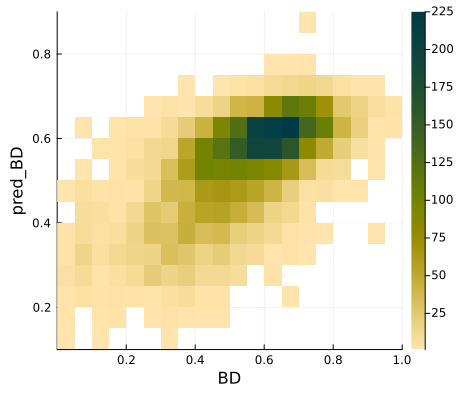

Plotting SOCconc: valid points = 56117


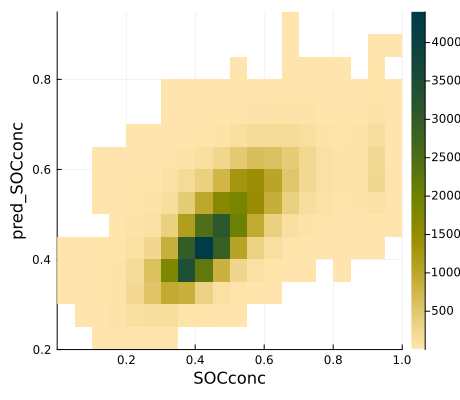

Plotting CF: valid points = 5194


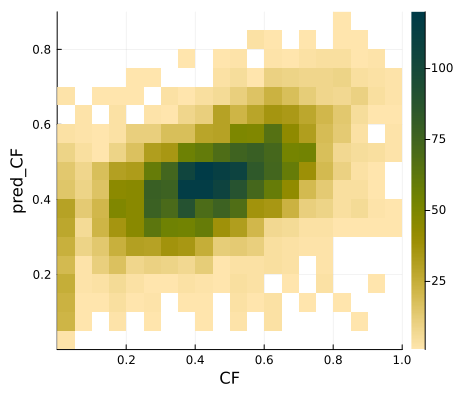

Plotting SOCdensity: valid points = 5194


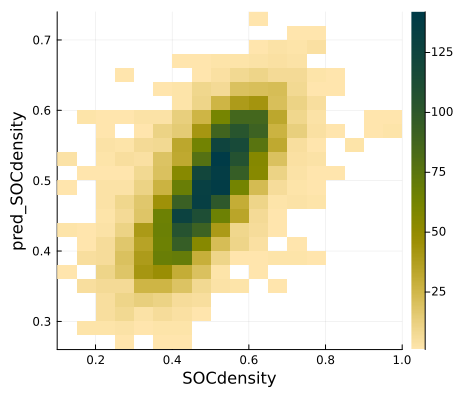

In [9]:
for tgt in ["BD", "SOCconc", "CF", "SOCdensity"]

    true_vals = rlt_pred[:, Symbol(tgt)]
    pred_vals = rlt_pred[:, Symbol("pred_", tgt)]

    # 过滤掉 invalid 值（避免 NaN 出图报错）
    mask = map(!isnan, true_vals) .& map(!isnan, pred_vals)
    x = true_vals[mask]
    y = pred_vals[mask]

    println("Plotting $tgt: valid points = ", length(x))

    plt = histogram2d(
        x, y;
        nbins = (30, 30),
        cbar = true,
        xlab = tgt,
        ylab = "pred_$tgt",
        color = cgrad(:bamako, rev=true),
        normalize = false,
        size = (460, 400),
    )

    display(plt)
end

Variable: pred_BD
  Valid count = 56117
  Min = 0.03444128496761876
  Max = 0.8710828213748402



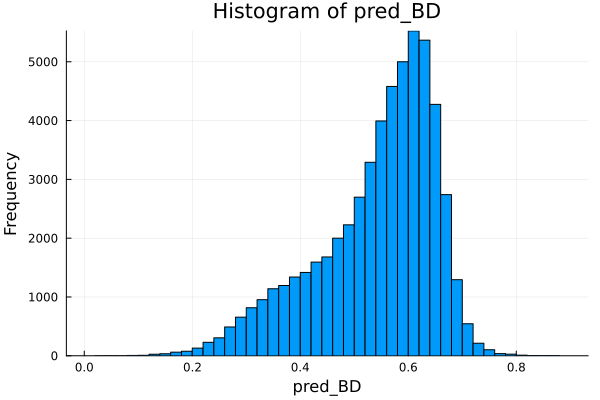

Variable: pred_SOCconc
  Valid count = 56117
  Min = 0.22402257
  Max = 0.92541355



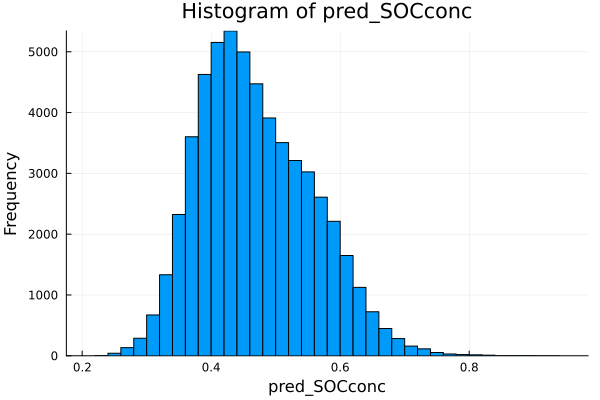

Variable: pred_CF
  Valid count = 56117
  Min = 0.0005329842
  Max = 0.8698329



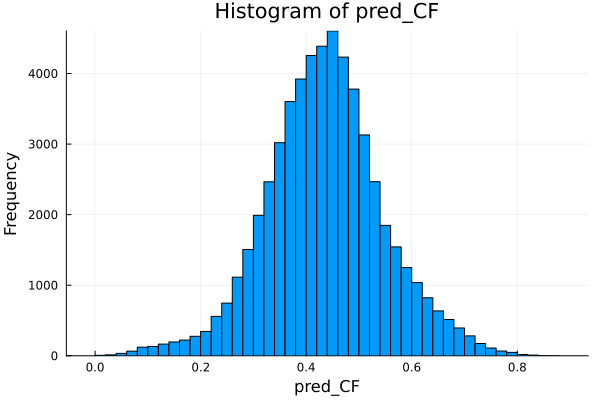

Variable: pred_SOCdensity
  Valid count = 56117
  Min = 0.2340269373291393
  Max = 0.7651828993675949



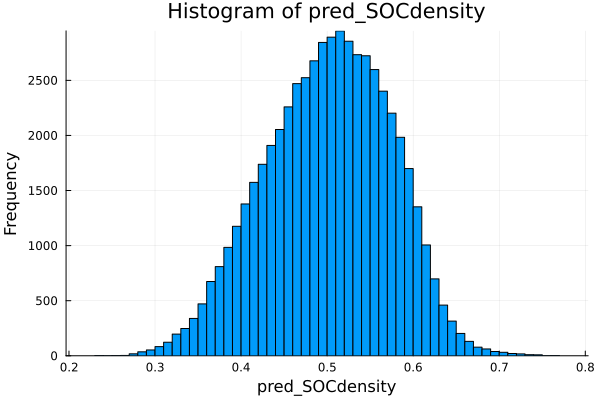

In [10]:
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = rlt_pred[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end
